In [287]:
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import average_precision_score


## Data Manipulation

In [288]:
raw_df = pd.read_pickle('../data/training_df.pkl')
ddict = pd.read_pickle('../data_dict/data_dictionary.pkl')

In [289]:
raw_df.head()

,PID,numerics,codes,to_event,target
0,0277965,"[[], [], [], [], [], [], [], [], []]","[[33, 4, 69, 48, 465, 57, 59], [25, 119], [513...","[0, 3, 4, 22, 78, 83, 364, 1469, 1479]",0
1,0277965,"[[], [], [], [], [], [], [], [], [], [], []]","[[33, 4, 69, 48, 465, 57, 59], [25, 119], [513...","[0, 3, 4, 22, 78, 83, 364, 1469, 1479, 1546, 1...",0
2,0277965,"[[], [], [], [], [], [], [], [], [], [], [], [...","[[33, 4, 69, 48, 465, 57, 59], [25, 119], [513...","[0, 3, 4, 22, 78, 83, 364, 1469, 1479, 1546, 1...",1
3,0742011,"[[], [], [], [], [], [], [], []]","[[32, 68, 5, 48, 119, 56, 25, 58, 59], [47, 53...","[0, 18, 62, 67, 113, 180, 259, 260]",0
4,0742011,"[[], [], [], [], [], [], [], [], [], [], [], []]","[[32, 68, 5, 48, 119, 56, 25, 58, 59], [47, 53...","[0, 18, 62, 67, 113, 180, 259, 260, 278, 293, ...",0


In [290]:
event_days = []
features = []
ids = []
targets = []

for _, row in raw_df.iterrows():
    feature = row.codes
    pid = row.PID
    target = row.target
    
    for day in range(len(row.to_event)):
        event_days.append(row.to_event[day])
        features.append(feature[day])
        ids.append(pid)
        targets.append(target)

long_event = pd.DataFrame({
    'PID': ids,
    'feature': features,
    'event_day': event_days,
    'target': targets
})        
        
    

In [291]:
long_event.head()

,PID,feature,event_day,target
0,0277965,"[33, 4, 69, 48, 465, 57, 59]",0,0
1,0277965,"[25, 119]",3,0
2,0277965,[513],4,0
3,0277965,"[47, 23, 533, 119, 535, 26]",22,0
4,0277965,"[47, 532, 23, 537, 538]",78,0


In [292]:
mlb = MultiLabelBinarizer()
df = long_event.join(pd.DataFrame(mlb.fit_transform(long_event.pop('feature')),
                                  columns=mlb.classes_,
                                  index=long_event.index).add_prefix('var_'))

In [293]:
df.head()

,PID,event_day,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,...,var_611,var_612,var_613,var_615,var_616,var_617,var_618,var_619,var_620,var_621
0,0277965,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0277965,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0277965,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0277965,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0277965,78,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Aggregated data

By PID:

- Sum all the features
- Take the event day
- Target is 1 if there is ever a relapse

In [294]:
feature_agg = df.groupby('PID').sum().reset_index().drop(['event_day', 'target'], axis=1)
target_agg = df.groupby('PID')['target'].max().reset_index()
day_agg = df.groupby('PID')['event_day'].mean().reset_index()

df_agg = pd.merge(day_agg, target_agg, on='PID', how='inner')
df_agg = pd.merge(df_agg, feature_agg, on='PID', how='inner')


In [295]:
df_agg.shape

(235, 194)

In [296]:
print('Number of unique patients')
df_agg.PID.nunique()

Number of unique patients


235

In [297]:
print('Count of relapse vs. no-relapse')
df_agg.target.value_counts()

Count of relapse vs. no-relapse


0    163
1     72
Name: target, dtype: int64

## Boosting

In [298]:
# import packages
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split

rand_seed = 123456

In [299]:
df_agg.head()

,PID,event_day,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,...,var_611,var_612,var_613,var_615,var_616,var_617,var_618,var_619,var_620,var_621
0,0277965,632.088235,1,6,0,0,1,3,0,0,...,0,0,0,0,0,3,3,0,0,6
1,0742011,259.244898,0,18,0,0,14,0,6,0,...,0,0,0,0,8,31,4,1,0,44
2,0867591,182.363636,0,2,0,1,3,0,2,0,...,0,0,0,1,1,5,0,0,0,7
3,2015958,488.615385,0,0,1,0,2,2,0,0,...,0,0,0,0,0,2,2,0,0,4
4,2055759,134.769231,0,2,1,0,0,0,0,2,...,0,0,0,0,0,6,0,0,0,6


## Gradient Boosting Aggregated Dataset

In [300]:
X = df_agg.iloc[:, 3:] # pd.concat([df_agg.event_day, df_agg.iloc[:, 3:]], axis=1)
y = df_agg.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = rand_seed)

In [301]:
y_train.value_counts()

0    125
1     51
Name: target, dtype: int64

In [302]:
y_test.value_counts()

0    38
1    21
Name: target, dtype: int64

In [303]:
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=400, random_state=rand_seed)
#gb = XGBClassifier(learning_rate=0.2, n_estimators=500)
gb.fit(X_train, y_train)
train_pred = gb.predict(X_train)
y_score = gb.predict(X_test)

In [304]:
print('F1 score for train set: ', f1_score(y_train, train_pred))
print('F1 score for test set: ', f1_score(y_test, y_score))

F1 score for train set:  1.0
F1 score for test set:  0.36363636363636365


In [305]:
from sklearn.metrics import accuracy_score

print('ACC score for train set: ', accuracy_score(y_train, train_pred))
print('ACC score for test set: ', accuracy_score(y_test, y_score))

ACC score for train set:  1.0
ACC score for test set:  0.6440677966101694


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.316041 using {'learning_rate': 0.06, 'n_estimators': 400}
0.046336 (0.090276) with: {'learning_rate': 0.05, 'n_estimators': 25}
0.064492 (0.132041) with: {'learning_rate': 0.05, 'n_estimators': 50}
0.107491 (0.158896) with: {'learning_rate': 0.05, 'n_estimators': 100}
0.187271 (0.129134) with: {'learning_rate': 0.05, 'n_estimators': 200}
0.250891 (0.166636) with: {'learning_rate': 0.05, 'n_estimators': 300}
0.311709 (0.165008) with: {'learning_rate': 0.05, 'n_estimators': 400}
0.295944 (0.165761) with: {'learning_rate': 0.05, 'n_estimators': 500}
0.069031 (0.143741) with: {'learning_rate': 0.06, 'n_estimators': 25}
0.096003 (0.155009) with: {'learning_rate': 0.06, 'n_estimators': 50}
0.177992 (0.145402) with: {'learning_rate': 0.06, 'n_estimators': 100}
0.231648 (0.178044) with: {'learning_rate': 0.06, 'n_estimators': 200}
0.290485 (0.146544) with: {'learning_rate': 0.06, 'n_estimators': 300}
0.316041 (0.133260) with: {'learning_rate': 0.06, 'n_estimators': 400}
0.265314 (0.155

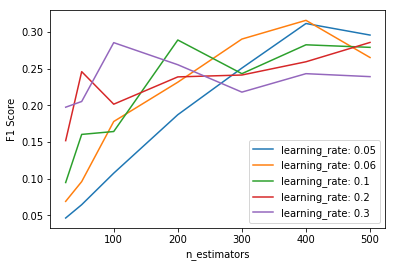

In [306]:
#from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy
from matplotlib import pyplot

# grid search
model = GradientBoostingClassifier()
n_estimators = [25, 50, 100, 200, 300, 400, 500]
learning_rate = [0.05, 0.06, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('F1 Score')
pyplot.savefig('n_estimators_vs_learning_rate.png')

In [307]:
print('Confusion matrix for train set: ')
confusion_matrix(y_train, train_pred)

Confusion matrix for train set: 


array([[125,   0],
       [  0,  51]])

In [308]:
print('Confusion matrix for train set: ')
confusion_matrix(y_test, y_score)

Confusion matrix for train set: 


array([[32,  6],
       [15,  6]])

In [309]:
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score (PR-AUC): {0:0.2f}'.format(
      average_precision))

Average precision-recall score (PR-AUC): 0.40


Text(0.5, 1.0, '2-class Precision-Recall curve: PR-AUC=0.40')

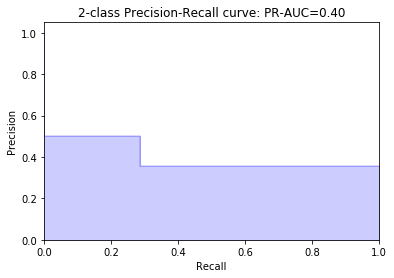

In [310]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: PR-AUC={0:0.2f}'.format(
          average_precision))


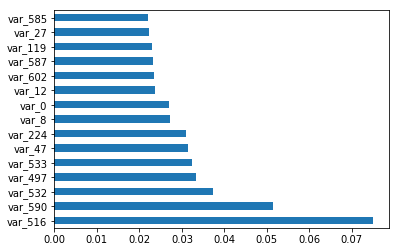

In [311]:
feature_importance = pd.Series(gb.feature_importances_, index=X_train.columns)
feature_importance.nlargest(15).plot(kind='barh')

In [312]:
feature_list = list(feature_importance.nlargest(15).index.str.slice(start=4).astype(int))
[ddict.get(x) for x in feature_list]

['w_mrd_type___2',
 'w_treatment_induction_8',
 'w_sub_agvh_grade_1',
 'rx_indication_maintenance_consolidation',
 'w_sub_agvh_grade_2',
 'gvhd_event',
 'pb_blasts_0',
 'bm_blasts_1',
 'Chemotherapy',
 'bmblasts_known',
 'w_treatment_targeted___19',
 'w_treatment_induction_5',
 'isp_event',
 'e_response_1',
 'w_treatment_induction_3']

## Gradient Boosting with upsampled aggregated dataset

In [313]:
from sklearn.utils import resample
relapse = df_agg[df_agg.target==1]
no_relapse =df_agg[df_agg.target==0]

relapse_upsampled = resample(relapse, replace=True, n_samples=len(no_relapse))
upsampled = pd.concat([relapse_upsampled, no_relapse])
upsampled.target.value_counts()

1    163
0    163
Name: target, dtype: int64

In [314]:
X = upsampled.iloc[:, 3:] # pd.concat([upsampled.event_day, upsampled.iloc[:, 3:]], axis = 1)
y = upsampled.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = rand_seed)

In [315]:
gb = GradientBoostingClassifier(learning_rate=0.05, n_estimators=400, random_state=rand_seed)
gb.fit(X_train, y_train)
train_pred = gb.predict(X_train)
y_score = gb.predict(X_test)

In [316]:
print('F1 score for train set: ', f1_score(y_train, train_pred))
print('F1 score for test set: ', f1_score(y_test, y_score))

F1 score for train set:  1.0
F1 score for test set:  0.7755102040816326


In [317]:
print('Confusion matrix for train set: ')
confusion_matrix(y_train, train_pred)

Confusion matrix for train set: 


array([[130,   0],
       [  0, 114]])

In [318]:
print('Confusion matrix for train set: ')
confusion_matrix(y_test, y_score)

Confusion matrix for train set: 


array([[22, 11],
       [11, 38]])

In [319]:
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score (PR-AUC): {0:0.2f}'.format(
      average_precision))

Average precision-recall score (PR-AUC): 0.74


Text(0.5, 1.0, '2-class Precision-Recall curve: PR-AUC=0.74')

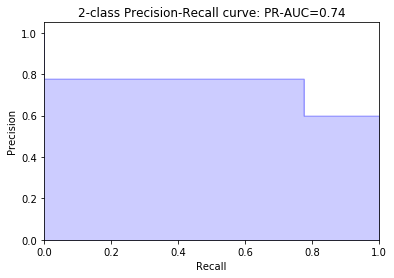

In [320]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: PR-AUC={0:0.2f}'.format(
          average_precision))


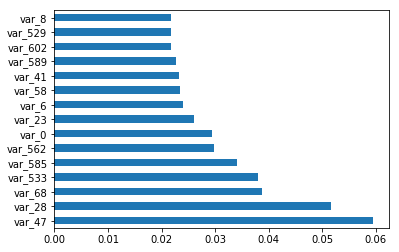

In [321]:
feature_importance = pd.Series(gb.feature_importances_, index=X_train.columns)
feature_importance.nlargest(15).plot(kind='barh')

In [322]:
feature_list = list(feature_importance.nlargest(15).index.str.slice(start=4).astype(int))

In [323]:
[ddict.get(x) for x in feature_list]

['gvhd_event',
 'e_response_2',
 'hct1_stage___3',
 'w_sub_agvh_grade_2',
 'w_treatment_induction_3',
 'w_treatment_consolidation_1',
 'Chemotherapy',
 'e_gvhd_1',
 'al_origin___3',
 'hct1_mrd___1',
 'extramed_type___7',
 'w_treatment_induction_7',
 'w_treatment_targeted___19',
 'w_relapse_cns_details___4',
 'bm_blasts_1']